In [6]:
import numpy as np

The physical scale of the TDR sensor, i.e., the sensor length, unit in "meter"

In [7]:
# the length of TDR sensor portions, cable + connection + probe
CableLength=0.5
SolderLength=0.075
ProbeLength=0.30

# some physical constant
LightSpeed=300000000                   # unit m/s

The physical parameter of cable, connection, and probe. 

1. $L$ -- inductance
1. $C$ -- capacitance
1. $G$ -- resistance
1. $R$ -- resistance

Some details are listed as follows.

1. Suppose the source resistence and the cable impedence is 75$\Omega$, and the phase velocity in the cable is $70\%c$.
2. The Probe $C$ is directly related to the water content. For pure water, assume $\varepsilon=80*\varepsilon_0$, and use $d=30$, $D=3$ mm for the probe rod. Then apply the equation
$$C(x)=\frac{\pi\varepsilon(x)}{cosh^{-1}(d/D)}$$

In [8]:
# cable
L_Cable=3.5714e-07
C_Cable=6.3492e-11
R_Cable=0
G_Cable=0

# connection
L_Connc=1.5714e-07
C_Connc=6.3492e-11
R_Connc=0
G_Connc=0

# probe
L_Probe=2.0e-07
C_Probe=7.5e-10
R_Probe=0
G_Probe=0

Boundary conditions, source point and loading point

In [29]:
# Source point
InputVoltage=1000/1000             # unit V
InputRasingTime=3e-10              # unit s
CableImped=75                      # unit ohm
R_Source=75                        # unit ohm
beta=1/(InputRasingTime)
Vin=CableImped/(R_Source+CableImped)*InputVoltage

# define the input voltage and its derivative
Vs=lambda t : Vin*(1-np.exp(-beta*t))
dVsdt=lambda t : Vin*beta*np.exp(-beta*t)

# -------------------------------------------------------
# Loading point
R_Loading=2000


Finite difference numerical solver (Implicit Scheme). For simple, we just consider the LC-circuit here.

In [26]:
Xdomain = CableLength+SolderLength+ProbeLength
dx = 0.002
NX = np.ceil(Xdomain/dx)
dx = Xdomain/NX
dt = dx/LightSpeed

NX = int(NX)
TotalTimeStep = int(2.5e3)                # number of time step, suppose sufficient long

No_Cable = int(np.floor(CableLength/dx)+1)
No_Connc = int(np.floor((CableLength+SolderLength)/dx)+1-No_Cable)
No_Probe = int(NX-No_Cable-No_Connc)

# set-up the spatial distribution of L, C, R, G
L = np.concatenate((L_Cable*np.ones(No_Cable), L_Connc*np.ones(No_Connc), L_Probe*np.ones(No_Probe+1)))
C = np.concatenate((C_Cable*np.ones(No_Cable), C_Connc*np.ones(No_Connc), C_Probe*np.ones(No_Probe+1)))
R = np.concatenate((R_Cable*np.ones(No_Cable), R_Connc*np.ones(No_Connc), R_Probe*np.ones(No_Probe+1)))
G = np.concatenate((G_Cable*np.ones(No_Cable), G_Connc*np.ones(No_Connc), G_Probe*np.ones(No_Probe+1)))

# start the numerical solver, use 100% explicit FDM
# establish the coefficient matrix
Coef_A = np.zeros((NX+1,3))
Coef_B = np.zeros(NX+1)
Rs = R_Source
Rl = R_Loading

# x=0 Source
Coef_A[0,1] = 1+Rs/L[0]/dx*dt
Coef_A[0,2] = -Rs/L[0]/dx*dt

# intermediate point
for NN in np.arange(1,NX):
    Coef_A[NN,0] = -0.25*(dt*dt)/(dx*dx)/(L[NN]*C[NN])
    Coef_A[NN,1] = 1.0+0.5*(dt*dt)/(dx*dx)/(L[NN]*C[NN])
    Coef_A[NN,2] = -0.25*(dt*dt)/(dx*dx)/(L[NN]*C[NN])

# x=NX+1 loading
Coef_A[NX,0]=-dt*Rl/L[NX]/dx
Coef_A[NX,1]=1+dt*Rl/L[NX]/dx

# define the iterator and the time save
Vprev_1=np.zeros(NX+1)
Vprev_2=np.zeros(NX+1)
Vcurr=np.zeros(NX+1)
Vrecord=np.zeros((NX+1,500+1))
SaveTimeStep=int(TotalTimeStep/500)
WaveFormSimu=np.zeros(TotalTimeStep+1)
SaveIter=0

for TT in np.arange(TotalTimeStep+1):
    
    Vprev_2 = np.copy(Vprev_1)
    Vprev_1 = np.copy(Vcurr)
    
    # assign from the previous step
    WaveFormSimu[TT]=Vcurr[0]
    
    if TT%SaveTimeStep==0:
        Vrecord[:,SaveIter]=Vcurr
        # print('I am working: '+str(float(SaveIter/5))+'%')
        SaveIter=SaveIter+1
    
    # time iteration    
    Coef_B[0]=Vprev_1[0]+dt*dVsdt(TT*dt)
    Coef_B[NX]=Vprev_1[NX]
    
    for NN in np.arange(1,NX):
        Coef_B[NN]=2*Vprev_1[NN]-Vprev_2[NN]+(dt*dt)/(dx*dx)/(L[NN]*C[NN])*\
        (0.5*(Vprev_1[NN+1]+Vprev_1[NN-1]-2*Vprev_1[NN])+\
        0.25*(Vprev_2[NN+1]+Vprev_2[NN-1]-2*Vprev_2[NN]))
    
        
    # Thomas linear solver
    Coef_AA=np.copy(Coef_A)
    Coef_BB=np.copy(Coef_B)
    
    for NN in np.arange(1,NX+1):
        ll=Coef_AA[NN,0]/Coef_AA[NN-1,1]
        Coef_AA[NN,1]=Coef_AA[NN,1]-Coef_AA[NN-1,2]*ll
        Coef_BB[NN]=Coef_BB[NN]-Coef_BB[NN-1]*ll
        
    Vcurr[NX]=Coef_BB[NX]/Coef_AA[NX,1]
    for NN in np.arange(NX-1,-1,-1):
        Vcurr[NN]=(Coef_BB[NN]-Vcurr[NN+1]*Coef_AA[NN,2])/Coef_AA[NN,1]

# finish the computaiton and start to plot
print('finished')

I am working: 0.0%
I am working: 0.2%
I am working: 0.4%
I am working: 0.6%
I am working: 0.8%
I am working: 1.0%
I am working: 1.2%
I am working: 1.4%
I am working: 1.6%
I am working: 1.8%
I am working: 2.0%
I am working: 2.2%
I am working: 2.4%
I am working: 2.6%
I am working: 2.8%
I am working: 3.0%
I am working: 3.2%
I am working: 3.4%
I am working: 3.6%
I am working: 3.8%
I am working: 4.0%
I am working: 4.2%
I am working: 4.4%
I am working: 4.6%
I am working: 4.8%
I am working: 5.0%
I am working: 5.2%
I am working: 5.4%
I am working: 5.6%
I am working: 5.8%
I am working: 6.0%
I am working: 6.2%
I am working: 6.4%
I am working: 6.6%
I am working: 6.8%
I am working: 7.0%
I am working: 7.2%
I am working: 7.4%
I am working: 7.6%
I am working: 7.8%
I am working: 8.0%
I am working: 8.2%
I am working: 8.4%
I am working: 8.6%
I am working: 8.8%
I am working: 9.0%
I am working: 9.2%
I am working: 9.4%
I am working: 9.6%
I am working: 9.8%
I am working: 10.0%
I am working: 10.2%
I am worki

I am working: 86.8%
I am working: 87.0%
I am working: 87.2%
I am working: 87.4%
I am working: 87.6%
I am working: 87.8%
I am working: 88.0%
I am working: 88.2%
I am working: 88.4%
I am working: 88.6%
I am working: 88.8%
I am working: 89.0%
I am working: 89.2%
I am working: 89.4%
I am working: 89.6%
I am working: 89.8%
I am working: 90.0%
I am working: 90.2%
I am working: 90.4%
I am working: 90.6%
I am working: 90.8%
I am working: 91.0%
I am working: 91.2%
I am working: 91.4%
I am working: 91.6%
I am working: 91.8%
I am working: 92.0%
I am working: 92.2%
I am working: 92.4%
I am working: 92.6%
I am working: 92.8%
I am working: 93.0%
I am working: 93.2%
I am working: 93.4%
I am working: 93.6%
I am working: 93.8%
I am working: 94.0%
I am working: 94.2%
I am working: 94.4%
I am working: 94.6%
I am working: 94.8%
I am working: 95.0%
I am working: 95.2%
I am working: 95.4%
I am working: 95.6%
I am working: 95.8%
I am working: 96.0%
I am working: 96.2%
I am working: 96.4%
I am working: 96.6%


plot the direct numerical result.

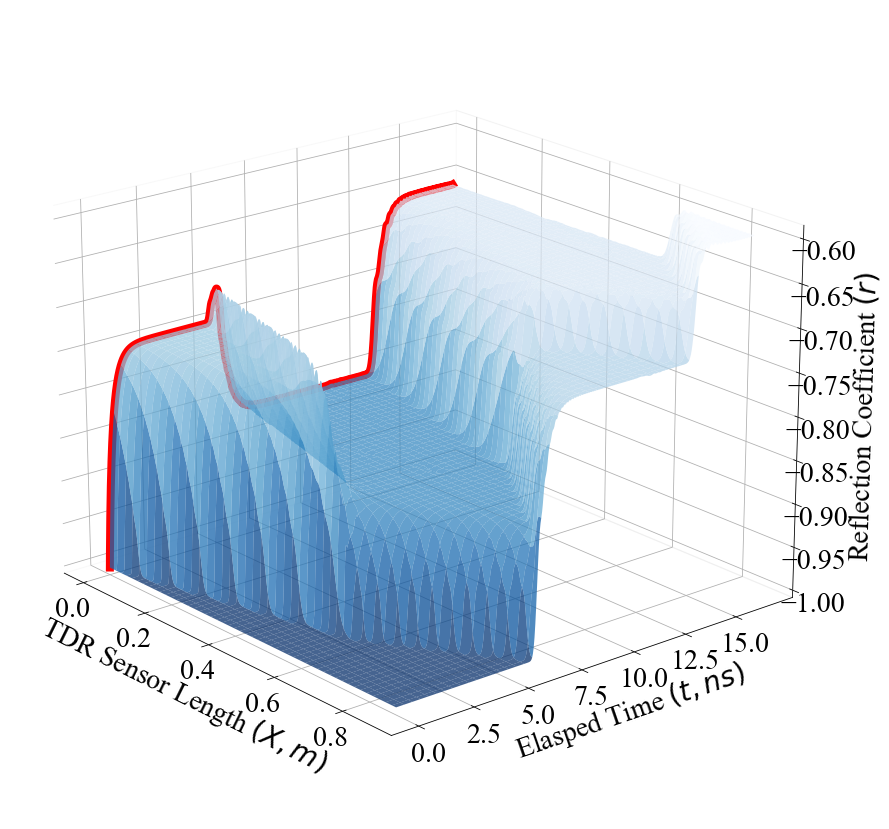

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

fig = plt.figure(figsize=(15,15))
plt.rcParams['font.size'] = '28'
plt.rcParams['font.family'] = 'Times New Roman'

ax  = fig.add_subplot(111, projection='3d')

XX=np.arange(0,Xdomain+0.001,dx)
TT=np.arange(0,TotalTimeStep+0.001,TotalTimeStep/500)*dt*1e9
TTT,XXX=np.meshgrid(TT,XX)

surf1 = ax.plot_surface(XXX,TTT, Vrecord-1, cmap='Blues_r', alpha=0.75)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(20, 320)

TT_0=np.arange(0,TotalTimeStep+1)*dt*1e9
XX_0=np.zeros(TT_0.shape)

ax.plot3D(XX_0, TT_0, WaveFormSimu-1,'red', linewidth=8)

ax.set_xlabel('TDR Sensor Length $(X,m)$',labelpad=16)
ax.set_ylabel('Elasped Time $(t, ns)$',labelpad=16)
ax.set_zlabel('Reflection Coefficient $(r)$',labelpad=16)

plt.show()

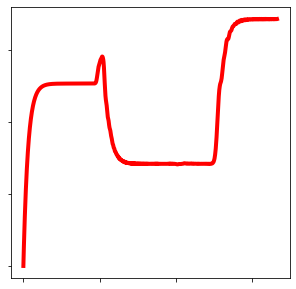

In [28]:
fig_1 = plt.figure(figsize=(5,5))
plt.rcParams['font.size'] = '20'
plt.rcParams['font.family'] = 'Times New Roman'

plt.plot(TT_0, WaveFormSimu-1,'r', linewidth=4)

ax1 = plt.gca()
ax1.axes.xaxis.set_ticklabels([])
ax1.axes.yaxis.set_ticklabels([])

plt.show()